# Covid Cases by US States

[Coivd Data](https://www.kaggle.com/fireballbyedimyrnmom/us-counties-covid-19-dataset?select=us-counties.csv)

The New York Times is releasing a series of data files with cumulative counts of coronavirus cases in the United States, at the state and county level, over time. We are compiling this time series data from state and local governments and health departments in an attempt to provide a complete record of the ongoing outbreak.

- date: from Jan. 21, 2020 and is being updated constantly (2020-07-11 for this set)
- fips =a specific code for counties, this may vary for metro areas
- county
- state
- cases: total cases to the date
- deaths: total deaths to the date

I am implementing a multi-state LSTM where we aim to predict the cases by state. We will turn the total cases into daily new cases for the predictions.

Additionally the states will be labeled with a corresponding code number:

dictionary = {['Alabama':1, 'Alaska':2, 'Arizona':3, 'Arkansas':4, 'California':5, 'Colorado':6, 'Connecticut':7, 'Delaware':8, 'District of Columbia':9, 'Florida':10, 'Georgia':11, 'Guam':12, 'Hawaii':13, 'Idaho':14, 'Illinois':15, 'Indiana':16, 'Iowa':17, 'Kansas':18, 'Kentucky':19, 'Louisiana':20, 'Maine':21, 'Maryland':22, 'Massachusetts':23, 'Michigan':24, 'Minnesota':25, 'Mississippi':26, 'Missouri':27, 'Montana':28, 'Nebraska':29, 'Nevada':30, 'New Hampshire':31, 'New Jersey':32, 'New Mexico':33, 'New York':34, 'North Carolina':35, 'North Dakota':36, 'Northern Mariana Islands':37, 'Ohio':38, 'Oklahoma':39, 'Oregon':40, 'Pennsylvania':41, 'Puerto Rico':42, 'Rhode Island':43, 'South Carolina':44, 'South Dakota':45, 'Tennessee':46, 'Texas':47, 'Utah':48, 'Vermont':49, 'Virgin Islands':50, 'Virginia':52, 'Washington':52, 'West Virginia':53, 'Wisconsin':54, 'Wyoming':55]}

In [40]:
import os
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler


#clean data
directory = os.getcwd()
dataset = pd.read_csv(os.path.join(directory, 'us-counties.csv'))
dataset = dataset.drop(['county', 'fips', 'deaths'],1)

#Clean data and prepare for NN
## Change cumulitive cases into daily new cases
## normalize data for the lstm model
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = dataset.groupby(['date', 'state'])['cases'].sum().reset_index() #Sum cases from the counties
least_collected = min(dataset['state'].value_counts())
#Start each timseries on 03/28/2020 as was the first day every state had
df = dataset.sort_values("date").groupby("state").tail(least_collected).reset_index()
df = df.drop(['index'],1)
pivoted_df = df.pivot(index='date', columns='state', values='cases')
state_names = pivoted_df.columns
states_array = np.transpose(np.array(pivoted_df))
daily_cases = np.empty((states_array.shape[0], states_array.shape[1]-1))

for i in range(0, len(states_array)):
    daily_cases[i] = states_array[i][1:] - states_array[i][:-1]

#Change days with a loss of cumulitive cases to 0
daily_cases[daily_cases < 0] = 0
daily_cases = np.transpose(daily_cases)
daily_cases = scaler.fit_transform(daily_cases)
print(daily_cases.shape)

(470, 55)


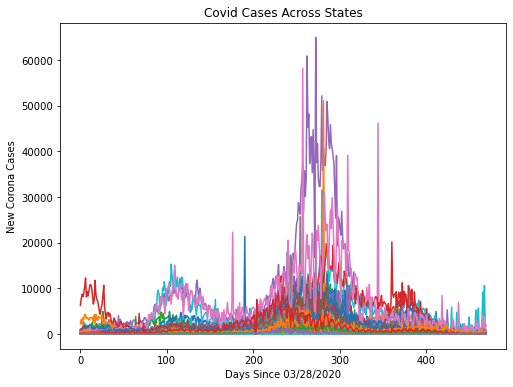

In [41]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('Days Since 03/28/2020')
ax.set_ylabel('New Corona Cases')
ax.plot(scaler.inverse_transform(daily_cases))
ax.set_title('Covid Cases Across States');
fig.savefig(directory+ '/images/covid_cases.pdf')
#Large spike during winter 2020/2021

In [42]:
#train set: 70%, test set 30%
x_all = daily_cases[:-1][:]
x_train = x_all[0:int(x_all.shape[0]*0.7),:]
x_test = x_all[int(x_all.shape[0]*0.7):,:]
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

y_all = daily_cases[1:][:]
y_train = y_all[0:int(y_all.shape[0]*0.7),:]
y_test = y_all[int(y_all.shape[0]*0.7):,:]

print('xall', x_all.shape)
print('yall', y_all.shape)

print('x_train', x_train.shape)
print('x_test', x_test.shape)

print('y_train', y_train.shape)
print('y_test', y_test.shape)

xall (469, 55)
yall (469, 55)
x_train (328, 1, 55)
x_test (141, 1, 55)
y_train (328, 55)
y_test (141, 55)


# The Model

For choosing the nodes, number of layers etc. we used:

- Batch Size of 64, as is common
- input layer with nuerons equal to the input size 55 (numeber of states)
- output layer equal to the number of states
- the nuerons for the hidden layer where estimated from the following equation
$$

$$

In [43]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(55, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True, activation="relu"))
#model.add(LSTM(47, return_sequences=True, activation='relu'))
model.add(LSTM(47, activation="relu"))
model.add(Dense(x_train.shape[2], activation="relu"))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=250, validation_split=0.2, batch_size=64, verbose=0)


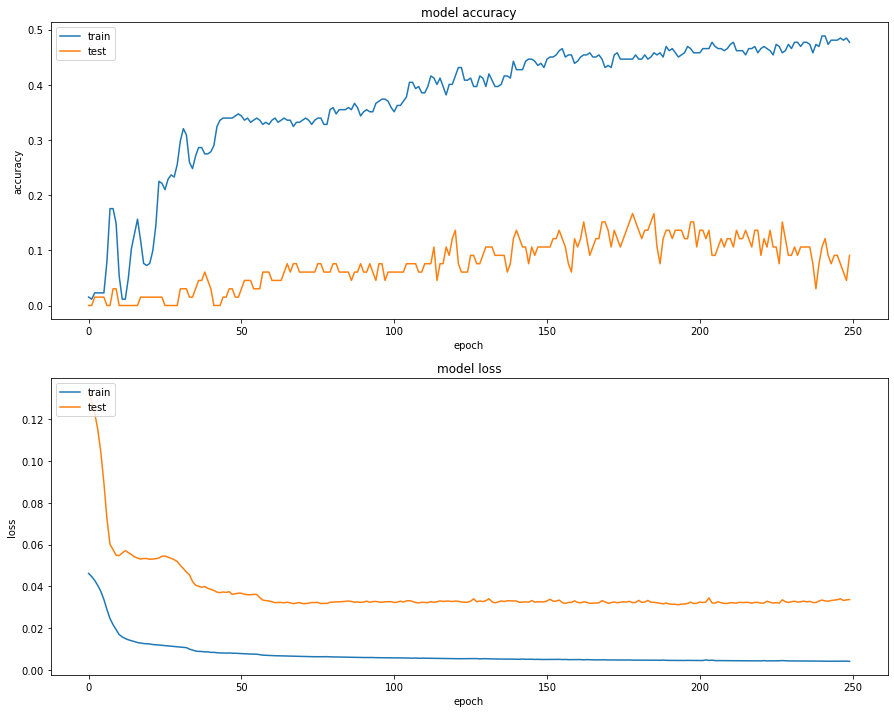

In [44]:
#history = model.fit(x_train, y_train, epochs=100, validation_split=0.2, shuffle=True, verbose = 0)

fig, (ax1,ax2) = plt.subplots(nrows= 2,figsize=(15,12))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()


Train Score: 0.10 RMSE
Test Score: 0.10 RMSE
Train Score: 1384.28 RMSE
Test Score: 1163.66 RMSE


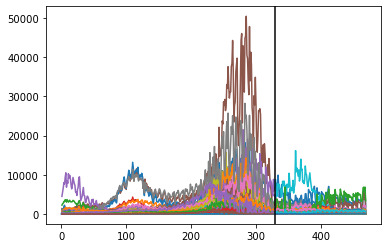

In [45]:
# make predictions
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
trainScore = math.sqrt(mean_squared_error(y_train, trainPredict[:,:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, testPredict[:,:]))
print('Test Score: %.2f RMSE' % (testScore))

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform(y_test)
daily_cases_original = scaler.inverse_transform(daily_cases)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train, trainPredict[:,:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, testPredict[:,:]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(daily_cases)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[1:len(trainPredict)+1, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(daily_cases)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+1:len(daily_cases), :] = testPredict

# plot baseline and predictions
plt.plot(daily_cases[:][0])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.axvline(len(trainPredict)+1, color= "black")
plt.show()



668.6241134751773
1131.5098


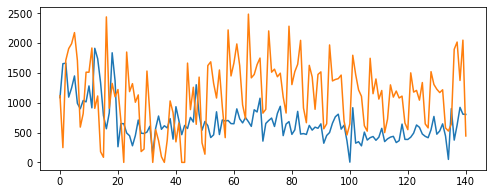

In [46]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(daily_cases_original[len(trainPredict)+1:len(daily_cases), 2])
ax.plot(testPredict[:,2]);
print(np.mean(daily_cases_original[len(trainPredict)+1:len(daily_cases), 2]))
print(np.mean(testPredict[:,2]))
plt.show()

In [47]:
#PLOTS for states 1-10
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 20))
for j in range(0, 10):
    axes[j].set_title(state_names[j], fontsize = 10)
    axes[j].plot(trainPredictPlot[:,j], color = 'orange', label = 'TrainPrediction')
    axes[j].plot(testPredictPlot[:,j], color = 'red', label = 'Test Prediction')
    axes[j].plot(daily_cases_original[:,j], color = 'lightblue', label = 'Real Data')
    axes[j].axvline(len(trainPredict)+1, linestyle='dashed', color = 'black', label = 'Test/Train cutoff')
plt.legend()
fig.text(0.5, 0.08, 'Day since 03/28/2020', va='center', ha='center', rotation='horizontal')
fig.text(0.08, 0.5, 'New COVID Cases', va='center', ha='center', rotation='vertical')
plt.savefig(directory+ '/images/states_1-10.pdf')
plt.close()
#PLOTS for states 11-20
set_number = 10
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 20))
for j in range(0, 10):
    axes[j].set_title(state_names[j+set_number], fontsize = 10)
    axes[j].plot(trainPredictPlot[:,j+set_number], color = 'orange', label = 'TrainPrediction')
    axes[j].plot(testPredictPlot[:,j+set_number], color = 'red', label = 'Test Prediction')
    axes[j].plot(daily_cases_original[:,j+set_number], color = 'lightblue', label = 'Real Data')
    axes[j].axvline(len(trainPredict)+1, linestyle='dashed', color = 'black', label = 'Test/Train cutoff')
plt.legend()
fig.text(0.5, 0.08, 'Day since 03/28/2020', va='center', ha='center', rotation='horizontal')
fig.text(0.08, 0.5, 'New COVID Cases', va='center', ha='center', rotation='vertical')
plt.savefig(directory+ '/images/states_11-20.pdf')
plt.close()
##PLOTS for states 21-30
set_number = 20
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 20))
for j in range(0, 10):
    axes[j].set_title(state_names[j+set_number], fontsize = 10)
    axes[j].plot(trainPredictPlot[:,j+set_number], color = 'orange', label = 'TrainPrediction')
    axes[j].plot(testPredictPlot[:,j+set_number], color = 'red', label = 'Test Prediction')
    axes[j].plot(daily_cases_original[:,j+set_number], color = 'lightblue', label = 'Real Data')
    axes[j].axvline(len(trainPredict)+1, linestyle='dashed', color = 'black', label = 'Test/Train cutoff')
plt.legend()
fig.text(0.5, 0.08, 'Day since 03/28/2020', va='center', ha='center', rotation='horizontal')
fig.text(0.08, 0.5, 'New COVID Cases', va='center', ha='center', rotation='vertical')
plt.savefig(directory+ '/images/states_21-30.pdf')
plt.close()
##PLOTS for states 31-40
set_number = 30
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 20))
for j in range(0, 10):
    axes[j].set_title(state_names[j+set_number], fontsize = 10)
    axes[j].plot(trainPredictPlot[:,j+set_number], color = 'orange', label = 'TrainPrediction')
    axes[j].plot(testPredictPlot[:,j+set_number], color = 'red', label = 'Test Prediction')
    axes[j].plot(daily_cases_original[:,j+set_number], color = 'lightblue', label = 'Real Data')
    axes[j].axvline(len(trainPredict)+1, linestyle='dashed', color = 'black', label = 'Test/Train cutoff')
plt.legend()
fig.text(0.5, 0.08, 'Day since 03/28/2020', va='center', ha='center', rotation='horizontal')
fig.text(0.08, 0.5, 'New COVID Cases', va='center', ha='center', rotation='vertical')
plt.savefig(directory+ '/images/states_31-40.pdf')
plt.close()
##PLOTS for states 41-50
set_number = 40
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 20))
for j in range(0, 10):
    axes[j].set_title(state_names[j+set_number], fontsize = 10)
    axes[j].plot(trainPredictPlot[:,j+set_number], color = 'orange', label = 'TrainPrediction')
    axes[j].plot(testPredictPlot[:,j+set_number], color = 'red', label = 'Test Prediction')
    axes[j].plot(daily_cases_original[:,j+set_number], color = 'lightblue', label = 'Real Data')
    axes[j].axvline(len(trainPredict)+1, linestyle='dashed', color = 'black', label = 'Test/Train cutoff')
plt.legend()
fig.text(0.5, 0.08, 'Day since 03/28/2020', va='center', ha='center', rotation='horizontal')
fig.text(0.08, 0.5, 'New COVID Cases', va='center', ha='center', rotation='vertical')
plt.savefig(directory+ '/images/states_41-50.pdf')
plt.close()
#PLOTS for states 51-55
set_number = 50
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 20))
for j in range(0, 5):
    axes[j].set_title(state_names[j+set_number], fontsize = 10)
    axes[j].plot(trainPredictPlot[:,j+set_number], color = 'orange', label = 'TrainPrediction')
    axes[j].plot(testPredictPlot[:,j+set_number], color = 'red', label = 'Test Prediction')
    axes[j].plot(daily_cases_original[:,j+set_number], color = 'lightblue', label = 'Real Data')
    axes[j].axvline(len(trainPredict)+1, linestyle='dashed', color = 'black', label = 'Test/Train cutoff')
fig.text(0.5, 0.08, 'Day since 03/28/2020', va='center', ha='center', rotation='horizontal')
fig.text(0.08, 0.5, 'New COVID Cases', va='center', ha='center', rotation='vertical')
plt.legend()
plt.savefig(directory+ '/images/states_51-55.pdf')
plt.close()